# 1. Importing modules and functions

In [3]:
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from molvs import standardize_smiles
from copy import deepcopy
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from catboost import CatBoostRegressor
from sklearn.svm import SVR
from sklearn.model_selection import permutation_test_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_predict
from sklearn import metrics
from sklearn.metrics import pairwise_distances
import joblib
import pickle
from numpy import savetxt
from padelpy import from_sdf
import shap
from tqdm.notebook import tqdm

In [4]:
def convert_smi_to_canon_smi(smi):    
    try:
        canon_smi = Chem.MolToSmiles(Chem.MolFromSmiles(smi),isomericSmiles = False)
    except:
        canon_smi='wrong_smiles'
    return canon_smi

In [5]:
def standart(smi):
    global m
    if smi!='wrong_smiles':
        try:
            smiles=standardize_smiles(smi)
            m = Chem.MolFromSmiles(smi)
        except:
            smi='error kekule'
    else:
        m = 'check the smiles'
    return m

## Load data and curation work set

In [7]:
# Set file path
df_ws=pd.read_csv('datasets/rat_LD50_WS.csv')
df_ws

,TAID,Pubchem CID,IUPAC Name,SMILES,Canonical_SMILES,InChIKey,rat_intravenous_LD50
0,TOX-3990,178,acetamide,CC(N)=O,CC(N)=O,DLFVBJFMPXGRIB-UHFFFAOYSA-N,0.674442
1,TOX-2407,180,propan-2-one,CC(C)=O,CC(C)=O,CSCPPACGZOOCGX-UHFFFAOYSA-N,1.023664
2,TOX-8193,12025,pyrrolidin-2-one,O=C1CCCN1,O=C1CCCN1,HNJBEVLQSNELDL-UHFFFAOYSA-N,1.072628
3,TOX-4318,1030,"propane-1,2-diol",CC(O)CO,CC(O)CO,DNIAPMSPPWPWGF-UHFFFAOYSA-N,1.073618
4,TOX-8477,99937,"2,3,3a,5,6,6a-hexahydrofuro[3,2-b]furan-3,6-diol",OC1COC2C(O)COC12,OC1COC2C(O)COC12,KLDXJTOLSGUMSJ-UHFFFAOYSA-N,1.123382
...,...,...,...,...,...,...,...
1853,TOX-43158,116224,2-diethoxyphosphorylsulfanylethyl-ethyl-methyl...,CCOP(=O)(OCC)SCC[S+](C)CC,CCOP(=O)(OCC)SCC[S+](C)CC,YDYNMVNUGKEYOS-UHFFFAOYSA-N,7.232647
1854,TOX-2075,14955,"9,10,21,25-tetramethoxy-15,15,30,30-tetramethy...",COc1ccc2cc1Oc1cc3c(cc1OC)CC[N+](C)(C)C3Cc1ccc(...,COc1ccc2cc1Oc1cc3c(cc1OC)CC[N+](C)(C)C3Cc1ccc(...,JFXBEKISTKFVAB-UHFFFAOYSA-N,7.270733
1855,TOX-43154,116216,2-diethoxyphosphorylsulfanylethyl(diethyl)sulf...,CCOP(=O)(OCC)SCC[S+](CC)CC,CCOP(=O)(OCC)SCC[S+](CC)CC,QACHTXIQQRWDTM-UHFFFAOYSA-N,7.458497
1856,TOX-43157,116222,2-dimethoxyphosphorylsulfanylethyl-ethyl-(2-et...,CCSCC[S+](CC)CCSP(=O)(OC)OC,CCSCC[S+](CC)CCSP(=O)(OC)OC,GICPMZCWCHOATC-UHFFFAOYSA-N,7.805466


##  Standardization  for work set

In [9]:
df_ws["Molecule"] = df_ws.apply(lambda x: standart(x.Canonical_SMILES), axis=1)
print('Kept data: ', len(df_ws), 'molecules')

Kept data:  1858 molecules


In [10]:
df_ws

,TAID,Pubchem CID,IUPAC Name,SMILES,Canonical_SMILES,InChIKey,rat_intravenous_LD50,Molecule
0,TOX-3990,178,acetamide,CC(N)=O,CC(N)=O,DLFVBJFMPXGRIB-UHFFFAOYSA-N,0.674442,<rdkit.Chem.rdchem.Mol object at 0x000001EBB04...
1,TOX-2407,180,propan-2-one,CC(C)=O,CC(C)=O,CSCPPACGZOOCGX-UHFFFAOYSA-N,1.023664,<rdkit.Chem.rdchem.Mol object at 0x000001EBB04...
2,TOX-8193,12025,pyrrolidin-2-one,O=C1CCCN1,O=C1CCCN1,HNJBEVLQSNELDL-UHFFFAOYSA-N,1.072628,<rdkit.Chem.rdchem.Mol object at 0x000001EBB04...
3,TOX-4318,1030,"propane-1,2-diol",CC(O)CO,CC(O)CO,DNIAPMSPPWPWGF-UHFFFAOYSA-N,1.073618,<rdkit.Chem.rdchem.Mol object at 0x000001EBB04...
4,TOX-8477,99937,"2,3,3a,5,6,6a-hexahydrofuro[3,2-b]furan-3,6-diol",OC1COC2C(O)COC12,OC1COC2C(O)COC12,KLDXJTOLSGUMSJ-UHFFFAOYSA-N,1.123382,<rdkit.Chem.rdchem.Mol object at 0x000001EBB04...
...,...,...,...,...,...,...,...,...
1853,TOX-43158,116224,2-diethoxyphosphorylsulfanylethyl-ethyl-methyl...,CCOP(=O)(OCC)SCC[S+](C)CC,CCOP(=O)(OCC)SCC[S+](C)CC,YDYNMVNUGKEYOS-UHFFFAOYSA-N,7.232647,<rdkit.Chem.rdchem.Mol object at 0x000001EBB05...
1854,TOX-2075,14955,"9,10,21,25-tetramethoxy-15,15,30,30-tetramethy...",COc1ccc2cc1Oc1cc3c(cc1OC)CC[N+](C)(C)C3Cc1ccc(...,COc1ccc2cc1Oc1cc3c(cc1OC)CC[N+](C)(C)C3Cc1ccc(...,JFXBEKISTKFVAB-UHFFFAOYSA-N,7.270733,<rdkit.Chem.rdchem.Mol object at 0x000001EBB05...
1855,TOX-43154,116216,2-diethoxyphosphorylsulfanylethyl(diethyl)sulf...,CCOP(=O)(OCC)SCC[S+](CC)CC,CCOP(=O)(OCC)SCC[S+](CC)CC,QACHTXIQQRWDTM-UHFFFAOYSA-N,7.458497,<rdkit.Chem.rdchem.Mol object at 0x000001EBB05...
1856,TOX-43157,116222,2-dimethoxyphosphorylsulfanylethyl-ethyl-(2-et...,CCSCC[S+](CC)CCSP(=O)(OC)OC,CCSCC[S+](CC)CCSP(=O)(OC)OC,GICPMZCWCHOATC-UHFFFAOYSA-N,7.805466,<rdkit.Chem.rdchem.Mol object at 0x000001EBB05...


In [11]:
y_tr=df_ws.rat_intravenous_LD50		
y_tr

0       0.674442
1       1.023664
2       1.072628
3       1.073618
4       1.123382
          ...   
1853    7.232647
1854    7.270733
1855    7.458497
1856    7.805466
1857    7.842020
Name: rat_intravenous_LD50, Length: 1858, dtype: float64

In [12]:
df = pd.DataFrame(df_ws, columns=["Canonical_SMILES"])
df

,Canonical_SMILES
0,CC(N)=O
1,CC(C)=O
2,O=C1CCCN1
3,CC(O)CO
4,OC1COC2C(O)COC12
...,...
1853,CCOP(=O)(OCC)SCC[S+](C)CC
1854,COc1ccc2cc1Oc1cc3c(cc1OC)CC[N+](C)(C)C3Cc1ccc(...
1855,CCOP(=O)(OCC)SCC[S+](CC)CC
1856,CCSCC[S+](CC)CCSP(=O)(OC)OC


In [13]:
df.to_csv('datasets/molecule_ws.smi', sep=',', index=False, header=False)

In [14]:
moldf_ws=df_ws.Molecule

##  Load data and curation test set

In [16]:
df_ts=pd.read_csv('datasets/rat_LD50_TS.csv')
df_ts

,TAID,Pubchem CID,IUPAC Name,SMILES,Canonical_SMILES,InChIKey,rat_intravenous_LD50
0,TOX-69105,9887295,"1-[6-(benzenesulfonyl)-3-hydroxy-2,2-dimethyl-...",CC1(C)Oc2ccc(S(=O)(=O)c3ccccc3)cc2C(N2CCCC2=O)C1O,CC1(C)Oc2ccc(S(=O)(=O)c3ccccc3)cc2C(N2CCCC2=O)C1O,LKAQWOWWTKFLNX-UHFFFAOYSA-N,0.496458
1,TOX-5811,8172,2-[2-(2-hydroxyethoxy)ethoxy]ethanol,OCCOCCOCCO,OCCOCCOCCO,ZIBGPFATKBEMQZ-UHFFFAOYSA-N,1.108409
2,TOX-2835,4101,"1,3,5,7-tetrazatricyclo[3.3.1.13,7]decane",C1N2CN3CN1CN(C2)C3,C1N2CN3CN1CN(C2)C3,VKYKSIONXSXAKP-UHFFFAOYSA-N,1.182929
3,TOX-3906,174,"ethane-1,2-diol",OCCO,OCCO,LYCAIKOWRPUZTN-UHFFFAOYSA-N,1.279650
4,TOX-5749,8087,1-(2-hydroxypropoxy)propan-2-ol,CC(O)COCC(C)O,CC(O)COCC(C)O,AZUXKVXMJOIAOF-UHFFFAOYSA-N,1.364244
...,...,...,...,...,...,...,...
460,TOX-44743,76419053,"[4-[4-[4-[3,5-dihydroxy-6-(hydroxymethyl)-4-[3...",CC1(C)CCC2(C(=O)OC3OC(CO)C(O)C(OC4OC(CO)C(O)C(...,CC1(C)CCC2(C(=O)OC3OC(CO)C(O)C(OC4OC(CO)C(O)C(...,UZQJVUCHXGYFLQ-UHFFFAOYSA-N,6.425276
461,TOX-5571,7871,2-[fluoro(methyl)phosphoryl]oxypropane,CC(C)OP(C)(=O)F,CC(C)OP(C)(=O)F,DYAHQFWOVKZOOW-UHFFFAOYSA-N,6.555355
462,TOX-5132,7305,"3-[fluoro(methyl)phosphoryl]oxy-2,2-dimethylbu...",CC(OP(C)(=O)F)C(C)(C)C,CC(OP(C)(=O)F)C(C)(C)C,GRXKLBBBQUKJJZ-UHFFFAOYSA-N,6.612129
463,TOX-23193,102302,"2-[ethoxy(methyl)phosphoryl]sulfanyl-N,N-dimet...",CCOP(C)(=O)SCCN(C)C,CCOP(C)(=O)SCCN(C)C,PKDYQTANBZBIRM-UHFFFAOYSA-N,7.094383


##  Standardization  for test set

In [18]:
df_ts["Molecule"] = df_ts.apply(lambda x: standart(x.Canonical_SMILES), axis=1)
moldf_ts=df_ts[df_ts['SMILES']!='wrong_smiles']
print('Kept data: ', len(moldf_ts), 'molecules')

Kept data:  465 molecules


In [19]:
moldf_ts

,TAID,Pubchem CID,IUPAC Name,SMILES,Canonical_SMILES,InChIKey,rat_intravenous_LD50,Molecule
0,TOX-69105,9887295,"1-[6-(benzenesulfonyl)-3-hydroxy-2,2-dimethyl-...",CC1(C)Oc2ccc(S(=O)(=O)c3ccccc3)cc2C(N2CCCC2=O)C1O,CC1(C)Oc2ccc(S(=O)(=O)c3ccccc3)cc2C(N2CCCC2=O)C1O,LKAQWOWWTKFLNX-UHFFFAOYSA-N,0.496458,<rdkit.Chem.rdchem.Mol object at 0x000001EBB04...
1,TOX-5811,8172,2-[2-(2-hydroxyethoxy)ethoxy]ethanol,OCCOCCOCCO,OCCOCCOCCO,ZIBGPFATKBEMQZ-UHFFFAOYSA-N,1.108409,<rdkit.Chem.rdchem.Mol object at 0x000001EBB05...
2,TOX-2835,4101,"1,3,5,7-tetrazatricyclo[3.3.1.13,7]decane",C1N2CN3CN1CN(C2)C3,C1N2CN3CN1CN(C2)C3,VKYKSIONXSXAKP-UHFFFAOYSA-N,1.182929,<rdkit.Chem.rdchem.Mol object at 0x000001EBB05...
3,TOX-3906,174,"ethane-1,2-diol",OCCO,OCCO,LYCAIKOWRPUZTN-UHFFFAOYSA-N,1.279650,<rdkit.Chem.rdchem.Mol object at 0x000001EBB05...
4,TOX-5749,8087,1-(2-hydroxypropoxy)propan-2-ol,CC(O)COCC(C)O,CC(O)COCC(C)O,AZUXKVXMJOIAOF-UHFFFAOYSA-N,1.364244,<rdkit.Chem.rdchem.Mol object at 0x000001EBB05...
...,...,...,...,...,...,...,...,...
460,TOX-44743,76419053,"[4-[4-[4-[3,5-dihydroxy-6-(hydroxymethyl)-4-[3...",CC1(C)CCC2(C(=O)OC3OC(CO)C(O)C(OC4OC(CO)C(O)C(...,CC1(C)CCC2(C(=O)OC3OC(CO)C(O)C(OC4OC(CO)C(O)C(...,UZQJVUCHXGYFLQ-UHFFFAOYSA-N,6.425276,<rdkit.Chem.rdchem.Mol object at 0x000001EBB05...
461,TOX-5571,7871,2-[fluoro(methyl)phosphoryl]oxypropane,CC(C)OP(C)(=O)F,CC(C)OP(C)(=O)F,DYAHQFWOVKZOOW-UHFFFAOYSA-N,6.555355,<rdkit.Chem.rdchem.Mol object at 0x000001EBB05...
462,TOX-5132,7305,"3-[fluoro(methyl)phosphoryl]oxy-2,2-dimethylbu...",CC(OP(C)(=O)F)C(C)(C)C,CC(OP(C)(=O)F)C(C)(C)C,GRXKLBBBQUKJJZ-UHFFFAOYSA-N,6.612129,<rdkit.Chem.rdchem.Mol object at 0x000001EBB05...
463,TOX-23193,102302,"2-[ethoxy(methyl)phosphoryl]sulfanyl-N,N-dimet...",CCOP(C)(=O)SCCN(C)C,CCOP(C)(=O)SCCN(C)C,PKDYQTANBZBIRM-UHFFFAOYSA-N,7.094383,<rdkit.Chem.rdchem.Mol object at 0x000001EBB05...


In [20]:
y_ts=moldf_ts.rat_intravenous_LD50	
y_ts

0      0.496458
1      1.108409
2      1.182929
3      1.279650
4      1.364244
         ...   
460    6.425276
461    6.555355
462    6.612129
463    7.094383
464    7.582023
Name: rat_intravenous_LD50, Length: 465, dtype: float64

In [195]:
df_ts = pd.DataFrame(moldf_ts, columns=["SMILES"])
df_ts

,SMILES
0,CC1(C)Oc2ccc(S(=O)(=O)c3ccccc3)cc2C(N2CCCC2=O)C1O
1,OCCOCCOCCO
2,C1N2CN3CN1CN(C2)C3
3,OCCO
4,CC(O)COCC(C)O
...,...
460,CC1(C)CCC2(C(=O)OC3OC(CO)C(O)C(OC4OC(CO)C(O)C(...
461,CC(C)OP(C)(=O)F
462,CC(OP(C)(=O)F)C(C)(C)C
463,CCOP(C)(=O)SCCN(C)C


In [197]:
df_ts.to_csv('datasets/molecule_ts.smi', sep=',', index=False, header=False)

# Calculation Fingerprints for work set

In [200]:
import glob
xml_files = glob.glob("fingerprints_xml/*.xml")
xml_files.sort()
xml_files

['fingerprints_xml\\AtomPairs2DFingerprintCount.xml',
 'fingerprints_xml\\AtomPairs2DFingerprinter.xml',
 'fingerprints_xml\\EStateFingerprinter.xml',
 'fingerprints_xml\\ExtendedFingerprinter.xml',
 'fingerprints_xml\\Fingerprinter.xml',
 'fingerprints_xml\\GraphOnlyFingerprinter.xml',
 'fingerprints_xml\\KlekotaRothFingerprintCount.xml',
 'fingerprints_xml\\KlekotaRothFingerprinter.xml',
 'fingerprints_xml\\MACCSFingerprinter.xml',
 'fingerprints_xml\\PubchemFingerprinter.xml',
 'fingerprints_xml\\SubstructureFingerprintCount.xml',
 'fingerprints_xml\\SubstructureFingerprinter.xml']

In [202]:
FP_list = ['AtomPairs2DCount',
 'AtomPairs2D',
 'EState',
 'CDKextended',
 'CDK',
 'CDKgraphonly',
 'KlekotaRothCount',
 'KlekotaRoth',
 'MACCS',
 'PubChem',
 'SubstructureCount',
 'Substructure']

In [204]:
fp = dict(zip(FP_list, xml_files))
fp

{'AtomPairs2DCount': 'fingerprints_xml\\AtomPairs2DFingerprintCount.xml',
 'AtomPairs2D': 'fingerprints_xml\\AtomPairs2DFingerprinter.xml',
 'EState': 'fingerprints_xml\\EStateFingerprinter.xml',
 'CDKextended': 'fingerprints_xml\\ExtendedFingerprinter.xml',
 'CDK': 'fingerprints_xml\\Fingerprinter.xml',
 'CDKgraphonly': 'fingerprints_xml\\GraphOnlyFingerprinter.xml',
 'KlekotaRothCount': 'fingerprints_xml\\KlekotaRothFingerprintCount.xml',
 'KlekotaRoth': 'fingerprints_xml\\KlekotaRothFingerprinter.xml',
 'MACCS': 'fingerprints_xml\\MACCSFingerprinter.xml',
 'PubChem': 'fingerprints_xml\\PubchemFingerprinter.xml',
 'SubstructureCount': 'fingerprints_xml\\SubstructureFingerprintCount.xml',
 'Substructure': 'fingerprints_xml\\SubstructureFingerprinter.xml'}

# 6.Descriptor calculation for work set

In [207]:
fp

{'AtomPairs2DCount': 'fingerprints_xml\\AtomPairs2DFingerprintCount.xml',
 'AtomPairs2D': 'fingerprints_xml\\AtomPairs2DFingerprinter.xml',
 'EState': 'fingerprints_xml\\EStateFingerprinter.xml',
 'CDKextended': 'fingerprints_xml\\ExtendedFingerprinter.xml',
 'CDK': 'fingerprints_xml\\Fingerprinter.xml',
 'CDKgraphonly': 'fingerprints_xml\\GraphOnlyFingerprinter.xml',
 'KlekotaRothCount': 'fingerprints_xml\\KlekotaRothFingerprintCount.xml',
 'KlekotaRoth': 'fingerprints_xml\\KlekotaRothFingerprinter.xml',
 'MACCS': 'fingerprints_xml\\MACCSFingerprinter.xml',
 'PubChem': 'fingerprints_xml\\PubchemFingerprinter.xml',
 'SubstructureCount': 'fingerprints_xml\\SubstructureFingerprintCount.xml',
 'Substructure': 'fingerprints_xml\\SubstructureFingerprinter.xml'}

## PubChem FPs

In [315]:
from padelpy import padeldescriptor

fingerprint = 'PubChem'

fingerprint_output_file = ''.join([fingerprint,'.csv']) 
fingerprint_descriptortypes = fp[fingerprint]

padeldescriptor(mol_dir='datasets/molecule_ws.smi', 
                d_file=fingerprint_output_file,
                descriptortypes= fingerprint_descriptortypes,
                detectaromaticity=True,
                standardizenitro=True,
                standardizetautomers=True,
                threads=2,
                removesalt=True,
                log=True,
                fingerprints=True)

In [35]:
descriptors_PubChem = pd.read_csv('PubChem.csv')

In [37]:
descriptors_PubChem

,Name,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,AUTOGEN_molecule_ws_1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,AUTOGEN_molecule_ws_2,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,AUTOGEN_molecule_ws_3,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,AUTOGEN_molecule_ws_4,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,AUTOGEN_molecule_ws_5,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1853,AUTOGEN_molecule_ws_1854,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1854,AUTOGEN_molecule_ws_1855,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1855,AUTOGEN_molecule_ws_1856,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1856,AUTOGEN_molecule_ws_1857,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [39]:
descriptors_PubChem[descriptors_PubChem. isna(). any(axis=1)]

,Name,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880


In [41]:
x_tr = descriptors_PubChem.drop('Name', axis=1)

In [43]:
x_tr = np.array(x_tr, dtype=np.float32)
y_tr = np.array(y_tr, dtype=np.float32)

In [335]:
savetxt('models/Padels/x_tr_PubChem.csv', x_tr, delimiter=',')

In [336]:
x_tr.shape

(1858, 881)

# 7.Descriptor calculation for test set

In [86]:
from padelpy import padeldescriptor

fingerprint = 'PubChem'

fingerprint_output_file = ''.join([fingerprint,'_ts.csv']) #PubChem.csv
fingerprint_descriptortypes = fp[fingerprint]

padeldescriptor(mol_dir='datasets/molecule_ts.smi', 
                d_file=fingerprint_output_file, #'PubChem.csv'
                #descriptortypes='PubChem.xml', 
                descriptortypes= fingerprint_descriptortypes,
                detectaromaticity=True,
                standardizenitro=True,
                standardizetautomers=True,
                threads=2,
                removesalt=True,
                log=False,
                fingerprints=True)

In [45]:
descriptors_PubChem_ts = pd.read_csv('PubChem_ts.csv')

In [47]:
x_ts = descriptors_PubChem_ts.drop('Name', axis=1)

In [49]:
x_ts.shape

(465, 881)

# CatBoostRegressor

In [74]:
cv=KFold(n_splits=5, random_state=42, shuffle=True)

In [341]:
%%time
model = CatBoostRegressor()
parameters = {'depth' : [6,8,10],
              'learning_rate' : [0.01, 0.05, 0.1],
              'iterations'    : [100,500, 1000]
              }

grid = GridSearchCV(estimator=model, param_grid = parameters, n_jobs=-1, cv = cv)
grid.fit(x_tr, y_tr, verbose=False)

CPU times: total: 24min 43s
Wall time: 42min 22s


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=<catboost.core.CatBoostRegressor object at 0x00000226C49AC350>,
             n_jobs=-1,
             param_grid={'depth': [6, 8, 10], 'iterations': [100, 500, 1000],
                         'learning_rate': [0.01, 0.05, 0.1]})

In [342]:
best_CatBR = grid.best_estimator_

In [343]:
grid.best_params_

{'depth': 10, 'iterations': 1000, 'learning_rate': 0.05}

In [344]:
y_pred_ws_GBR = best_CatBR.predict(x_tr)

In [345]:
R2_WS = round(r2_score(y_tr, y_pred_ws_GBR), 2)
R2_WS

0.96

In [346]:
RMSE_WS=round(np.sqrt(mean_squared_error(y_tr, y_pred_ws_GBR)), 2)
RMSE_WS

0.18

In [347]:
params={'verbose': False}

In [348]:
%%time
y_pred_CV_CatBR = cross_val_predict(best_CatBR, x_tr, y_tr, cv=cv, fit_params=params)

C:\Users\ovtti\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


CPU times: total: 1h 57min 25s
Wall time: 9min 31s


In [349]:
Q2_CV = round(r2_score(y_tr, y_pred_CV_CatBR), 2)
Q2_CV

0.6

In [350]:
RMSE_CV=round(np.sqrt(mean_squared_error(y_tr, y_pred_CV_CatBR)), 2)
RMSE_CV

0.62

# save the model to disk

In [421]:
pickle.dump(best_CatBR, open('Models/Padels/Toxicity_CatBoost_Pubchem.pkl', 'wb'))

# load the model from disk

In [51]:
best_CatBR = pickle.load(open('Models/Padels/Toxicity_CatBoost_Pubchem.pkl', 'rb'))

In [79]:
params={'verbose': False}

# Y-randomization GradientBoostingRegressor model

In [ ]:
permutations = 50
score, permutation_scores, pvalue = permutation_test_score(best_CatBR, x_tr, y_tr,
                                                           cv=cv, scoring='r2',
                                                           n_permutations=permutations,
                                                           n_jobs=-1,
                                                           fit_params=params,
                                                           random_state=42)
print('True score = ', score.round(2),
      '\nY-randomization = ', np.mean(permutation_scores).round(2),
      '\np-value = ', pvalue.round(4))

# 9. Prediction for test set's molecules

In [53]:
x_ts = np.array(x_ts, dtype=np.float32)
y_ts = np.array(y_ts, dtype=np.float32)

In [55]:
y_pred_GBR = best_CatBR.predict(x_ts)

In [57]:
Q2_TS = round(r2_score(y_ts, y_pred_GBR), 2)
Q2_TS

0.51

In [59]:
RMSE_TS=round(np.sqrt(mean_squared_error(y_ts, y_pred_GBR)), 2)
RMSE_TS

0.69

# 11. Estimating applicability domain. Method - Euclidian distances, K=1

In [440]:
neighbors_k= pairwise_distances(x_tr, n_jobs=-1)
neighbors_k.sort(0)

In [441]:
df_tr=pd.DataFrame(neighbors_k)
df_tr

,0,1,2,3,4,5,6,7,8,9,...,1848,1849,1850,1851,1852,1853,1854,1855,1856,1857
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,3.162278,3.316625,2.828427,2.000000,2.236068,2.449490,3.000000,2.645751,4.000000,1.000000,...,1.414214,0.000000,3.464102,0.000000,7.810250,0.000000,2.645751,0.000000,1.000000,0.000000
2,3.316625,3.464102,3.000000,2.000000,3.000000,2.828427,3.000000,3.000000,4.123106,1.000000,...,1.414214,7.280110,3.872983,2.645751,7.810250,0.000000,2.645751,0.000000,1.414214,0.000000
3,3.605551,3.464102,3.316625,2.645751,3.162278,2.828427,3.000000,3.162278,4.242640,1.732051,...,2.236068,7.549834,7.810250,3.741657,8.062258,0.000000,2.645751,0.000000,1.414214,0.000000
4,3.741657,3.464102,3.464102,2.828427,3.162278,3.000000,3.316625,3.316625,4.358899,2.236068,...,5.385165,7.681146,7.937254,4.582576,8.246211,1.000000,3.741657,1.000000,1.414214,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1853,15.033297,15.198684,14.456832,15.000000,14.491377,14.764823,14.628738,15.362291,14.317822,15.033297,...,14.456832,14.525839,15.874508,14.628738,14.832397,15.491934,14.525839,15.491934,15.556349,15.491934
1854,15.033297,15.264338,14.525839,15.000000,14.525839,14.798649,14.696939,15.362291,14.317822,15.033297,...,14.456832,14.560220,15.905973,14.662878,15.033297,15.491934,14.628738,15.491934,15.556349,15.491934
1855,15.165751,15.394804,14.628738,15.132746,14.899665,15.033297,15.000000,15.491934,14.352700,15.297058,...,14.764823,14.560220,15.905973,14.696939,15.066519,15.652476,14.662878,15.652476,15.716233,15.652476
1856,15.459625,15.620500,14.933185,15.684387,15.165751,15.491934,15.132746,15.905973,14.662878,15.652476,...,14.899665,14.696939,15.905973,15.000000,15.132746,15.874508,15.033297,15.874508,15.937377,15.874508


In [444]:
similarity= neighbors_k

In [446]:
Dmean=np.mean(similarity[1,:])

In [448]:
round(Dmean, 2)

3.27

In [450]:
std=np.std(similarity[1,:])

In [452]:
round(std, 2)

1.94

In [454]:
model_AD_limit=Dmean+std*0.5
print(np.round(model_AD_limit, 2))

4.24


In [455]:
neighbors_k_ts= pairwise_distances(x_tr,Y=x_ts, n_jobs=-1)
neighbors_k_ts.sort(0)

In [456]:
x_ts_AD=pd.DataFrame(neighbors_k_ts)
x_ts_AD

,0,1,2,3,4,5,6,7,8,9,...,455,456,457,458,459,460,461,462,463,464
0,6.855655,1.000000,3.872983,2.236068,1.000000,5.385165,3.464102,5.000000,1.414214,1.000000,...,1.000000,4.898980,1.000000,6.000000,5.196152,3.162278,3.162278,3.605551,3.162278,3.872983
1,6.855655,1.414214,4.000000,2.449490,1.732051,5.477226,3.872983,5.099020,1.414214,2.449490,...,2.000000,5.000000,1.414214,6.082763,5.567764,3.741657,3.162278,3.872983,3.316625,4.000000
2,7.211102,1.414214,4.472136,2.449490,1.732051,5.567764,4.000000,5.196152,1.414214,2.449490,...,3.000000,5.291502,1.414214,6.164414,5.656854,3.872983,3.316625,4.000000,3.464102,4.000000
3,7.211102,2.000000,4.690416,2.449490,1.732051,5.830952,4.123106,5.656854,2.449490,3.162278,...,5.000000,5.477226,1.414214,6.244998,6.082763,5.196152,3.464102,4.123106,3.741657,4.123106
4,7.211102,2.449490,4.690416,2.828427,2.000000,5.830952,4.242640,5.656854,2.645751,3.162278,...,5.656854,5.477226,1.414214,6.403124,6.082763,5.196152,3.605551,4.242640,3.741657,4.123106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1853,14.000000,15.000000,15.099669,15.132746,14.899665,14.696939,14.387495,14.764823,13.076696,12.922848,...,14.142136,12.449900,15.491934,13.453624,14.798649,14.764823,15.362291,15.264338,15.165751,15.000000
1854,14.000000,15.000000,15.264338,15.132746,14.899665,14.764823,14.456832,14.798649,13.114877,13.114877,...,14.832397,12.649111,15.491934,13.490738,14.832397,14.798649,15.459625,15.491934,15.165751,15.000000
1855,14.071247,15.264338,15.491934,15.264338,15.165751,14.798649,14.491377,14.866069,13.266500,13.304134,...,14.866069,12.649111,15.652476,13.527749,14.933185,14.899665,15.459625,15.491934,15.329710,15.165751
1856,14.142136,15.620500,15.811388,15.748015,15.588457,15.033297,14.933185,15.000000,13.527749,13.490738,...,14.966630,13.341664,15.811388,13.928389,15.033297,14.966630,16.062378,16.093477,15.874508,15.716233


In [457]:
similarity_ts= neighbors_k_ts
cpd_AD=similarity_ts[0,:]
cpd_value = np.round(cpd_AD, 3)
print(cpd_value)

[6.856 1.    3.873 2.236 1.    5.385 3.464 5.    1.414 1.    1.    5.745
 3.162 2.    4.69  2.449 5.292 2.449 7.    3.464 3.464 5.196 4.583 4.69
 3.606 3.742 2.828 4.899 1.414 3.162 3.    2.449 5.657 5.196 5.196 2.828
 5.292 5.477 4.583 6.164 3.464 2.449 5.099 3.317 7.874 1.    3.317 2.646
 1.732 1.732 3.162 2.449 1.732 6.325 3.317 2.646 2.236 5.831 4.243 4.
 4.796 2.    7.416 5.568 0.    5.196 5.385 3.742 5.745 5.657 3.606 4.472
 4.69  3.    7.937 5.099 2.828 5.745 1.414 3.317 4.583 4.583 1.    3.317
 2.828 4.123 3.606 5.831 4.    1.732 3.464 3.162 5.477 3.162 4.123 1.414
 3.606 4.243 1.    2.    4.583 2.236 4.796 5.477 4.123 3.    5.745 3.162
 4.69  2.828 5.196 5.292 3.742 3.742 1.    3.742 3.464 1.732 1.414 5.477
 5.657 2.    1.732 1.414 2.236 1.732 3.162 2.646 4.472 2.449 4.243 1.
 3.742 4.123 0.    5.292 4.    6.    4.796 1.732 3.162 4.472 5.745 0.
 5.745 4.69  4.243 4.69  3.606 3.    0.    3.162 4.359 4.    3.742 3.742
 4.583 6.083 1.732 4.472 2.828 4.472 4.796 2.828 7.28  4.123 

In [462]:
cpd_AD = np.where(cpd_value <= model_AD_limit, True, False)
print(cpd_AD)

[False  True  True  True  True False  True False  True  True  True False
  True  True False  True False  True False  True  True False False False
  True  True  True False  True  True  True  True False False False  True
 False False False False  True  True False  True False  True  True  True
  True  True  True  True  True False  True  True  True False  True  True
 False  True False False  True False False  True False False  True False
 False  True False False  True False  True  True False False  True  True
  True  True  True False  True  True  True  True False  True  True  True
  True  True  True  True False  True False False  True  True False  True
 False  True False False  True  True  True  True  True  True  True False
 False  True  True  True  True  True  True  True False  True  True  True
  True  True  True False  True False False  True  True False False  True
 False False  True False  True  True  True  True False  True  True  True
 False False  True False  True False False  True Fa

In [463]:
print("Coverage = ", round(sum(cpd_AD) / len(cpd_AD), 2))

Coverage =  0.71


In [465]:
print("Indices of substances included in AD = ", np.where(cpd_AD != 0)[0])

Indices of substances included in AD =  [  1   2   3   4   6   8   9  10  12  13  15  17  19  20  24  25  26  28
  29  30  31  35  40  41  43  45  46  47  48  49  50  51  52  54  55  56
  58  59  61  64  67  70  73  76  78  79  82  83  84  85  86  88  89  90
  91  93  94  95  96  97  98  99 101 104 105 107 109 112 113 114 115 116
 117 118 121 122 123 124 125 126 127 129 130 131 132 133 134 136 139 140
 143 146 148 149 150 151 153 154 155 158 160 163 165 166 167 168 169 171
 172 173 174 175 177 178 180 181 182 186 188 189 190 191 193 194 195 197
 198 200 201 202 203 204 205 206 207 210 211 213 216 217 219 220 222 223
 224 225 226 227 229 230 231 233 234 236 237 238 239 242 244 245 246 247
 248 249 250 251 253 255 256 258 259 260 262 263 264 269 270 272 273 274
 275 276 278 279 280 282 283 284 285 286 287 288 289 290 291 292 293 294
 295 296 297 299 300 303 304 305 307 308 309 310 311 312 313 314 315 316
 317 318 319 320 321 322 324 325 326 328 329 330 331 332 333 334 335 336
 338 341 34

In [468]:
out_Ad=list(np.where(cpd_AD == 0)[0])

# 12. Prediction only for molecules included in  AD

In [471]:
y_pred_GBR_ad=list(y_pred_GBR)

In [473]:
y_pred_GBR_ad[:] = [x for i,x in enumerate(y_pred_GBR_ad) if i not in out_Ad]

In [475]:
len(y_pred_GBR_ad)

329

In [477]:
y_ts_ad=list(y_ts)

In [479]:
y_ts_ad[:] = [x for i,x in enumerate(y_ts_ad) if i not in out_Ad]

In [481]:
len(y_ts_ad)

329

In [483]:
Q2_TS = round(r2_score(y_ts_ad, y_pred_GBR_ad), 2)
Q2_TS

0.59

In [485]:
RMSE_TS=round(np.sqrt(mean_squared_error(y_ts_ad, y_pred_GBR_ad)), 2)
RMSE_TS

0.62

# SVM model building and validation

In [488]:
param_grid = {"C": [10 ** i for i in range(0, 5)],
              "gamma": [10 ** i for i in range(-6, 0)]}

In [490]:
seed = 42
cv=KFold(n_splits=5, random_state=seed, shuffle=True)

In [492]:
svm = GridSearchCV(SVR(C=1.0, epsilon=0.2), param_grid, n_jobs=-1, cv=cv, verbose=1)

In [494]:
svm.fit(x_tr, y_tr)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=SVR(epsilon=0.2), n_jobs=-1,
             param_grid={'C': [1, 10, 100, 1000, 10000],
                         'gamma': [1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1]},
             verbose=1)

In [495]:
svm.best_params_
best_svm = svm.best_estimator_

In [496]:
svm.best_params_

{'C': 10, 'gamma': 0.01}

In [497]:
y_pred_ws_svm = best_svm.predict(x_tr)

In [498]:
R2_WS = round(r2_score(y_tr, y_pred_ws_svm), 2)
R2_WS

0.9

In [499]:
RMSE_WS=round(np.sqrt(mean_squared_error(y_tr, y_pred_ws_svm)), 2)
RMSE_WS

0.31

In [500]:
y_pred_CV_svm = cross_val_predict(best_svm, x_tr, y_tr, cv=cv)

In [501]:
Q2_CV = round(r2_score(y_tr, y_pred_CV_svm), 2)
Q2_CV

0.55

In [502]:
RMSE_CV=round(np.sqrt(mean_squared_error(y_tr, y_pred_CV_svm)), 2)
RMSE_CV

0.66

# 9. Prediction for test set's molecules

In [504]:
x_ts = np.array(x_ts, dtype=np.float32)
y_ts = np.array(y_ts, dtype=np.float32)

In [505]:
y_pred_svm = best_svm.predict(x_ts)

In [506]:
Q2_TS = round(r2_score(y_ts, y_pred_svm), 2)
Q2_TS

0.5

In [507]:
RMSE_TS=round(np.sqrt(mean_squared_error(y_ts, y_pred_svm)), 2)
RMSE_TS

0.7

save the model to disk

In [509]:
pickle.dump(best_svm, open('models/Padels/Toxicity_SVM_PubChem.pkl', 'wb'))

load the model from disk

In [31]:
best_svm = pickle.load(open('models/Padels/Toxicity_SVM_PubChem.pkl', 'rb'))

# 11. Estimating applicability domain. Method - Euclidian distances, K=1

In [511]:
neighbors_k= pairwise_distances(x_tr, n_jobs=-1)
neighbors_k.sort(0)

In [512]:
df_tr=pd.DataFrame(neighbors_k)
df_tr

,0,1,2,3,4,5,6,7,8,9,...,1848,1849,1850,1851,1852,1853,1854,1855,1856,1857
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,3.162278,3.316625,2.828427,2.000000,2.236068,2.449490,3.000000,2.645751,4.000000,1.000000,...,1.414214,0.000000,3.464102,0.000000,7.810250,0.000000,2.645751,0.000000,1.000000,0.000000
2,3.316625,3.464102,3.000000,2.000000,3.000000,2.828427,3.000000,3.000000,4.123106,1.000000,...,1.414214,7.280110,3.872983,2.645751,7.810250,0.000000,2.645751,0.000000,1.414214,0.000000
3,3.605551,3.464102,3.316625,2.645751,3.162278,2.828427,3.000000,3.162278,4.242640,1.732051,...,2.236068,7.549834,7.810250,3.741657,8.062258,0.000000,2.645751,0.000000,1.414214,0.000000
4,3.741657,3.464102,3.464102,2.828427,3.162278,3.000000,3.316625,3.316625,4.358899,2.236068,...,5.385165,7.681146,7.937254,4.582576,8.246211,1.000000,3.741657,1.000000,1.414214,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1853,15.033297,15.198684,14.456832,15.000000,14.491377,14.764823,14.628738,15.362291,14.317822,15.033297,...,14.456832,14.525839,15.874508,14.628738,14.832397,15.491934,14.525839,15.491934,15.556349,15.491934
1854,15.033297,15.264338,14.525839,15.000000,14.525839,14.798649,14.696939,15.362291,14.317822,15.033297,...,14.456832,14.560220,15.905973,14.662878,15.033297,15.491934,14.628738,15.491934,15.556349,15.491934
1855,15.165751,15.394804,14.628738,15.132746,14.899665,15.033297,15.000000,15.491934,14.352700,15.297058,...,14.764823,14.560220,15.905973,14.696939,15.066519,15.652476,14.662878,15.652476,15.716233,15.652476
1856,15.459625,15.620500,14.933185,15.684387,15.165751,15.491934,15.132746,15.905973,14.662878,15.652476,...,14.899665,14.696939,15.905973,15.000000,15.132746,15.874508,15.033297,15.874508,15.937377,15.874508


In [513]:
similarity= neighbors_k

In [514]:
Dmean=np.mean(similarity[1,:])

In [515]:
round(Dmean, 2)

3.27

In [516]:
std=np.std(similarity[1,:])

In [517]:
round(std, 2)

1.94

In [518]:
model_AD_limit=Dmean+std*0.5
print(np.round(model_AD_limit, 2))

4.24


In [519]:
neighbors_k_ts= pairwise_distances(x_tr,Y=x_ts, n_jobs=-1)
neighbors_k_ts.sort(0)

In [520]:
x_ts_AD=pd.DataFrame(neighbors_k_ts)
x_ts_AD

,0,1,2,3,4,5,6,7,8,9,...,455,456,457,458,459,460,461,462,463,464
0,6.855655,1.000000,3.872983,2.236068,1.000000,5.385165,3.464102,5.000000,1.414214,1.000000,...,1.000000,4.898980,1.000000,6.000000,5.196152,3.162278,3.162278,3.605551,3.162278,3.872983
1,6.855655,1.414214,4.000000,2.449490,1.732051,5.477226,3.872983,5.099020,1.414214,2.449490,...,2.000000,5.000000,1.414214,6.082763,5.567764,3.741657,3.162278,3.872983,3.316625,4.000000
2,7.211102,1.414214,4.472136,2.449490,1.732051,5.567764,4.000000,5.196152,1.414214,2.449490,...,3.000000,5.291502,1.414214,6.164414,5.656854,3.872983,3.316625,4.000000,3.464102,4.000000
3,7.211102,2.000000,4.690416,2.449490,1.732051,5.830952,4.123106,5.656854,2.449490,3.162278,...,5.000000,5.477226,1.414214,6.244998,6.082763,5.196152,3.464102,4.123106,3.741657,4.123106
4,7.211102,2.449490,4.690416,2.828427,2.000000,5.830952,4.242640,5.656854,2.645751,3.162278,...,5.656854,5.477226,1.414214,6.403124,6.082763,5.196152,3.605551,4.242640,3.741657,4.123106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1853,14.000000,15.000000,15.099669,15.132746,14.899665,14.696939,14.387495,14.764823,13.076696,12.922848,...,14.142136,12.449900,15.491934,13.453624,14.798649,14.764823,15.362291,15.264338,15.165751,15.000000
1854,14.000000,15.000000,15.264338,15.132746,14.899665,14.764823,14.456832,14.798649,13.114877,13.114877,...,14.832397,12.649111,15.491934,13.490738,14.832397,14.798649,15.459625,15.491934,15.165751,15.000000
1855,14.071247,15.264338,15.491934,15.264338,15.165751,14.798649,14.491377,14.866069,13.266500,13.304134,...,14.866069,12.649111,15.652476,13.527749,14.933185,14.899665,15.459625,15.491934,15.329710,15.165751
1856,14.142136,15.620500,15.811388,15.748015,15.588457,15.033297,14.933185,15.000000,13.527749,13.490738,...,14.966630,13.341664,15.811388,13.928389,15.033297,14.966630,16.062378,16.093477,15.874508,15.716233


In [521]:
similarity_ts= neighbors_k_ts
cpd_AD=similarity_ts[0,:]
cpd_value = np.round(cpd_AD, 3)
print(cpd_value)

[6.856 1.    3.873 2.236 1.    5.385 3.464 5.    1.414 1.    1.    5.745
 3.162 2.    4.69  2.449 5.292 2.449 7.    3.464 3.464 5.196 4.583 4.69
 3.606 3.742 2.828 4.899 1.414 3.162 3.    2.449 5.657 5.196 5.196 2.828
 5.292 5.477 4.583 6.164 3.464 2.449 5.099 3.317 7.874 1.    3.317 2.646
 1.732 1.732 3.162 2.449 1.732 6.325 3.317 2.646 2.236 5.831 4.243 4.
 4.796 2.    7.416 5.568 0.    5.196 5.385 3.742 5.745 5.657 3.606 4.472
 4.69  3.    7.937 5.099 2.828 5.745 1.414 3.317 4.583 4.583 1.    3.317
 2.828 4.123 3.606 5.831 4.    1.732 3.464 3.162 5.477 3.162 4.123 1.414
 3.606 4.243 1.    2.    4.583 2.236 4.796 5.477 4.123 3.    5.745 3.162
 4.69  2.828 5.196 5.292 3.742 3.742 1.    3.742 3.464 1.732 1.414 5.477
 5.657 2.    1.732 1.414 2.236 1.732 3.162 2.646 4.472 2.449 4.243 1.
 3.742 4.123 0.    5.292 4.    6.    4.796 1.732 3.162 4.472 5.745 0.
 5.745 4.69  4.243 4.69  3.606 3.    0.    3.162 4.359 4.    3.742 3.742
 4.583 6.083 1.732 4.472 2.828 4.472 4.796 2.828 7.28  4.123 

In [522]:
cpd_AD = np.where(cpd_value <= model_AD_limit, True, False)
print(cpd_AD)

[False  True  True  True  True False  True False  True  True  True False
  True  True False  True False  True False  True  True False False False
  True  True  True False  True  True  True  True False False False  True
 False False False False  True  True False  True False  True  True  True
  True  True  True  True  True False  True  True  True False  True  True
 False  True False False  True False False  True False False  True False
 False  True False False  True False  True  True False False  True  True
  True  True  True False  True  True  True  True False  True  True  True
  True  True  True  True False  True False False  True  True False  True
 False  True False False  True  True  True  True  True  True  True False
 False  True  True  True  True  True  True  True False  True  True  True
  True  True  True False  True False False  True  True False False  True
 False False  True False  True  True  True  True False  True  True  True
 False False  True False  True False False  True Fa

In [523]:
print("Coverage = ", round(sum(cpd_AD) / len(cpd_AD), 2))

Coverage =  0.71


In [524]:
print("Indices of substances included in AD = ", np.where(cpd_AD != 0)[0])

Indices of substances included in AD =  [  1   2   3   4   6   8   9  10  12  13  15  17  19  20  24  25  26  28
  29  30  31  35  40  41  43  45  46  47  48  49  50  51  52  54  55  56
  58  59  61  64  67  70  73  76  78  79  82  83  84  85  86  88  89  90
  91  93  94  95  96  97  98  99 101 104 105 107 109 112 113 114 115 116
 117 118 121 122 123 124 125 126 127 129 130 131 132 133 134 136 139 140
 143 146 148 149 150 151 153 154 155 158 160 163 165 166 167 168 169 171
 172 173 174 175 177 178 180 181 182 186 188 189 190 191 193 194 195 197
 198 200 201 202 203 204 205 206 207 210 211 213 216 217 219 220 222 223
 224 225 226 227 229 230 231 233 234 236 237 238 239 242 244 245 246 247
 248 249 250 251 253 255 256 258 259 260 262 263 264 269 270 272 273 274
 275 276 278 279 280 282 283 284 285 286 287 288 289 290 291 292 293 294
 295 296 297 299 300 303 304 305 307 308 309 310 311 312 313 314 315 316
 317 318 319 320 321 322 324 325 326 328 329 330 331 332 333 334 335 336
 338 341 34

In [525]:
out_Ad=list(np.where(cpd_AD == 0)[0])

# 12. Prediction only for molecules included in  AD

In [527]:
y_pred_svm_ad=list(y_pred_svm)

In [528]:
y_pred_svm_ad[:] = [x for i,x in enumerate(y_pred_svm_ad) if i not in out_Ad]

In [529]:
len(y_pred_svm_ad)

329

In [530]:
y_ts_ad=list(y_ts)

In [531]:
y_ts_ad[:] = [x for i,x in enumerate(y_ts_ad) if i not in out_Ad]

In [532]:
len(y_ts_ad)

329

In [533]:
Q2_TS = round(r2_score(y_ts_ad, y_pred_svm_ad), 2)
Q2_TS

0.58

In [534]:
RMSE_TS=round(np.sqrt(mean_squared_error(y_ts_ad, y_pred_svm_ad)), 2)
RMSE_TS

0.62

# Multi-layer Perceptron regressor

In [537]:
from sklearn.neural_network import MLPRegressor

In [538]:
param_grid ={"hidden_layer_sizes": [(400, 300, 200, 100),(100, 100, 100), (10, 10, 10),(50,)], "activation": ["tanh", "relu"], "solver": ["lbfgs", "sgd", "adam"], "alpha": [0.00005,0.0005], 'max_iter': [1000, 2000]}

In [539]:
m = GridSearchCV(MLPRegressor(), param_grid, n_jobs=-1, cv=cv, verbose=1)

In [540]:
m.fit(x_tr, y_tr)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=MLPRegressor(), n_jobs=-1,
             param_grid={'activation': ['tanh', 'relu'],
                         'alpha': [5e-05, 0.0005],
                         'hidden_layer_sizes': [(400, 300, 200, 100),
                                                (100, 100, 100), (10, 10, 10),
                                                (50,)],
                         'max_iter': [1000, 2000],
                         'solver': ['lbfgs', 'sgd', 'adam']},
             verbose=1)

In [541]:
best_MLPR = m.best_estimator_

In [542]:
m.best_params_

{'activation': 'relu',
 'alpha': 0.0005,
 'hidden_layer_sizes': (400, 300, 200, 100),
 'max_iter': 2000,
 'solver': 'adam'}

In [543]:
y_pred_ws_MLPR = best_MLPR.predict(x_tr)

In [544]:
R2_WS = round(r2_score(y_tr, y_pred_ws_MLPR), 2)
R2_WS

0.98

In [545]:
RMSE_WS=round(np.sqrt(mean_squared_error(y_tr, y_pred_ws_MLPR)), 2)
RMSE_WS

0.15

In [546]:
y_pred_CV_MLPR = cross_val_predict(best_MLPR, x_tr, y_tr, cv=cv)

In [547]:
y_pred_CV_MLPR

array([1.6909599, 2.4069014, 2.549587 , ..., 6.3774395, 6.7224007,
       6.3774395], dtype=float32)

In [548]:
Q2_CV = round(r2_score(y_tr, y_pred_CV_MLPR), 2)
Q2_CV

0.51

In [549]:
RMSE_CV=round(np.sqrt(mean_squared_error(y_tr, y_pred_CV_MLPR)), 2)
RMSE_CV

0.69

# 9. Prediction for test set's molecules

In [551]:
x_ts = np.array(x_ts, dtype=np.float32)
y_ts = np.array(y_ts, dtype=np.float32)

In [552]:
y_pred_MLPR = best_MLPR.predict(x_ts)

In [553]:
Q2_TS = round(r2_score(y_ts, y_pred_MLPR), 2)
Q2_TS

0.43

In [554]:
RMSE_TS=round(np.sqrt(mean_squared_error(y_ts, y_pred_MLPR)), 2)
RMSE_TS

0.75

# save the model to disk

In [556]:
pickle.dump(best_MLPR, open('models/Padels/Toxicity_MLPR_PubChem.pkl', 'wb'))

# load the model from disk

In [87]:
best_MLPR = pickle.load(open('models/Padels/Toxicity_MLPR_PubChem.pkl', 'rb'))

# 11. Estimating applicability domain. Method - Euclidian distances, K=1

In [558]:
neighbors_k= pairwise_distances(x_tr, n_jobs=-1)
neighbors_k.sort(0)

In [559]:
df_tr=pd.DataFrame(neighbors_k)
df_tr

,0,1,2,3,4,5,6,7,8,9,...,1848,1849,1850,1851,1852,1853,1854,1855,1856,1857
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,3.162278,3.316625,2.828427,2.000000,2.236068,2.449490,3.000000,2.645751,4.000000,1.000000,...,1.414214,0.000000,3.464102,0.000000,7.810250,0.000000,2.645751,0.000000,1.000000,0.000000
2,3.316625,3.464102,3.000000,2.000000,3.000000,2.828427,3.000000,3.000000,4.123106,1.000000,...,1.414214,7.280110,3.872983,2.645751,7.810250,0.000000,2.645751,0.000000,1.414214,0.000000
3,3.605551,3.464102,3.316625,2.645751,3.162278,2.828427,3.000000,3.162278,4.242640,1.732051,...,2.236068,7.549834,7.810250,3.741657,8.062258,0.000000,2.645751,0.000000,1.414214,0.000000
4,3.741657,3.464102,3.464102,2.828427,3.162278,3.000000,3.316625,3.316625,4.358899,2.236068,...,5.385165,7.681146,7.937254,4.582576,8.246211,1.000000,3.741657,1.000000,1.414214,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1853,15.033297,15.198684,14.456832,15.000000,14.491377,14.764823,14.628738,15.362291,14.317822,15.033297,...,14.456832,14.525839,15.874508,14.628738,14.832397,15.491934,14.525839,15.491934,15.556349,15.491934
1854,15.033297,15.264338,14.525839,15.000000,14.525839,14.798649,14.696939,15.362291,14.317822,15.033297,...,14.456832,14.560220,15.905973,14.662878,15.033297,15.491934,14.628738,15.491934,15.556349,15.491934
1855,15.165751,15.394804,14.628738,15.132746,14.899665,15.033297,15.000000,15.491934,14.352700,15.297058,...,14.764823,14.560220,15.905973,14.696939,15.066519,15.652476,14.662878,15.652476,15.716233,15.652476
1856,15.459625,15.620500,14.933185,15.684387,15.165751,15.491934,15.132746,15.905973,14.662878,15.652476,...,14.899665,14.696939,15.905973,15.000000,15.132746,15.874508,15.033297,15.874508,15.937377,15.874508


In [560]:
similarity= neighbors_k

In [561]:
Dmean=np.mean(similarity[1,:])

In [562]:
round(Dmean, 2)

3.27

In [563]:
std=np.std(similarity[1,:])

In [564]:
round(std, 2)

1.94

In [565]:
model_AD_limit=Dmean+std*0.5
print(np.round(model_AD_limit, 2))

4.24


In [566]:
neighbors_k_ts= pairwise_distances(x_tr,Y=x_ts, n_jobs=-1)
neighbors_k_ts.sort(0)

In [567]:
x_ts_AD=pd.DataFrame(neighbors_k_ts)
x_ts_AD

,0,1,2,3,4,5,6,7,8,9,...,455,456,457,458,459,460,461,462,463,464
0,6.855655,1.000000,3.872983,2.236068,1.000000,5.385165,3.464102,5.000000,1.414214,1.000000,...,1.000000,4.898980,1.000000,6.000000,5.196152,3.162278,3.162278,3.605551,3.162278,3.872983
1,6.855655,1.414214,4.000000,2.449490,1.732051,5.477226,3.872983,5.099020,1.414214,2.449490,...,2.000000,5.000000,1.414214,6.082763,5.567764,3.741657,3.162278,3.872983,3.316625,4.000000
2,7.211102,1.414214,4.472136,2.449490,1.732051,5.567764,4.000000,5.196152,1.414214,2.449490,...,3.000000,5.291502,1.414214,6.164414,5.656854,3.872983,3.316625,4.000000,3.464102,4.000000
3,7.211102,2.000000,4.690416,2.449490,1.732051,5.830952,4.123106,5.656854,2.449490,3.162278,...,5.000000,5.477226,1.414214,6.244998,6.082763,5.196152,3.464102,4.123106,3.741657,4.123106
4,7.211102,2.449490,4.690416,2.828427,2.000000,5.830952,4.242640,5.656854,2.645751,3.162278,...,5.656854,5.477226,1.414214,6.403124,6.082763,5.196152,3.605551,4.242640,3.741657,4.123106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1853,14.000000,15.000000,15.099669,15.132746,14.899665,14.696939,14.387495,14.764823,13.076696,12.922848,...,14.142136,12.449900,15.491934,13.453624,14.798649,14.764823,15.362291,15.264338,15.165751,15.000000
1854,14.000000,15.000000,15.264338,15.132746,14.899665,14.764823,14.456832,14.798649,13.114877,13.114877,...,14.832397,12.649111,15.491934,13.490738,14.832397,14.798649,15.459625,15.491934,15.165751,15.000000
1855,14.071247,15.264338,15.491934,15.264338,15.165751,14.798649,14.491377,14.866069,13.266500,13.304134,...,14.866069,12.649111,15.652476,13.527749,14.933185,14.899665,15.459625,15.491934,15.329710,15.165751
1856,14.142136,15.620500,15.811388,15.748015,15.588457,15.033297,14.933185,15.000000,13.527749,13.490738,...,14.966630,13.341664,15.811388,13.928389,15.033297,14.966630,16.062378,16.093477,15.874508,15.716233


In [568]:
similarity_ts= neighbors_k_ts
cpd_AD=similarity_ts[0,:]
cpd_value = np.round(cpd_AD, 3)
print(cpd_value)

[6.856 1.    3.873 2.236 1.    5.385 3.464 5.    1.414 1.    1.    5.745
 3.162 2.    4.69  2.449 5.292 2.449 7.    3.464 3.464 5.196 4.583 4.69
 3.606 3.742 2.828 4.899 1.414 3.162 3.    2.449 5.657 5.196 5.196 2.828
 5.292 5.477 4.583 6.164 3.464 2.449 5.099 3.317 7.874 1.    3.317 2.646
 1.732 1.732 3.162 2.449 1.732 6.325 3.317 2.646 2.236 5.831 4.243 4.
 4.796 2.    7.416 5.568 0.    5.196 5.385 3.742 5.745 5.657 3.606 4.472
 4.69  3.    7.937 5.099 2.828 5.745 1.414 3.317 4.583 4.583 1.    3.317
 2.828 4.123 3.606 5.831 4.    1.732 3.464 3.162 5.477 3.162 4.123 1.414
 3.606 4.243 1.    2.    4.583 2.236 4.796 5.477 4.123 3.    5.745 3.162
 4.69  2.828 5.196 5.292 3.742 3.742 1.    3.742 3.464 1.732 1.414 5.477
 5.657 2.    1.732 1.414 2.236 1.732 3.162 2.646 4.472 2.449 4.243 1.
 3.742 4.123 0.    5.292 4.    6.    4.796 1.732 3.162 4.472 5.745 0.
 5.745 4.69  4.243 4.69  3.606 3.    0.    3.162 4.359 4.    3.742 3.742
 4.583 6.083 1.732 4.472 2.828 4.472 4.796 2.828 7.28  4.123 

In [569]:
cpd_AD = np.where(cpd_value <= model_AD_limit, True, False)
print(cpd_AD)

[False  True  True  True  True False  True False  True  True  True False
  True  True False  True False  True False  True  True False False False
  True  True  True False  True  True  True  True False False False  True
 False False False False  True  True False  True False  True  True  True
  True  True  True  True  True False  True  True  True False  True  True
 False  True False False  True False False  True False False  True False
 False  True False False  True False  True  True False False  True  True
  True  True  True False  True  True  True  True False  True  True  True
  True  True  True  True False  True False False  True  True False  True
 False  True False False  True  True  True  True  True  True  True False
 False  True  True  True  True  True  True  True False  True  True  True
  True  True  True False  True False False  True  True False False  True
 False False  True False  True  True  True  True False  True  True  True
 False False  True False  True False False  True Fa

In [570]:
print("Coverage = ", round(sum(cpd_AD) / len(cpd_AD), 2))

Coverage =  0.71


In [571]:
print("Indices of substances included in AD = ", np.where(cpd_AD != 0)[0])

Indices of substances included in AD =  [  1   2   3   4   6   8   9  10  12  13  15  17  19  20  24  25  26  28
  29  30  31  35  40  41  43  45  46  47  48  49  50  51  52  54  55  56
  58  59  61  64  67  70  73  76  78  79  82  83  84  85  86  88  89  90
  91  93  94  95  96  97  98  99 101 104 105 107 109 112 113 114 115 116
 117 118 121 122 123 124 125 126 127 129 130 131 132 133 134 136 139 140
 143 146 148 149 150 151 153 154 155 158 160 163 165 166 167 168 169 171
 172 173 174 175 177 178 180 181 182 186 188 189 190 191 193 194 195 197
 198 200 201 202 203 204 205 206 207 210 211 213 216 217 219 220 222 223
 224 225 226 227 229 230 231 233 234 236 237 238 239 242 244 245 246 247
 248 249 250 251 253 255 256 258 259 260 262 263 264 269 270 272 273 274
 275 276 278 279 280 282 283 284 285 286 287 288 289 290 291 292 293 294
 295 296 297 299 300 303 304 305 307 308 309 310 311 312 313 314 315 316
 317 318 319 320 321 322 324 325 326 328 329 330 331 332 333 334 335 336
 338 341 34

In [572]:
out_Ad=list(np.where(cpd_AD == 0)[0])

# 12. Prediction only for molecules included in  AD

In [574]:
y_pred_MLPR_ad=list(y_pred_MLPR)

In [575]:
y_pred_MLPR_ad[:] = [x for i,x in enumerate(y_pred_MLPR_ad) if i not in out_Ad]

In [576]:
len(y_pred_MLPR_ad)

329

In [577]:
y_ts_ad=list(y_ts)

In [578]:
y_ts_ad[:] = [x for i,x in enumerate(y_ts_ad) if i not in out_Ad]

In [579]:
len(y_ts_ad)

329

In [580]:
Q2_TS = round(r2_score(y_ts_ad, y_pred_MLPR_ad), 2)
Q2_TS

0.5

In [581]:
RMSE_TS=round(np.sqrt(mean_squared_error(y_ts_ad, y_pred_MLPR_ad)), 2)
RMSE_TS

0.68

# k-nearest neighbors

In [583]:
from sklearn.neighbors import KNeighborsRegressor

In [584]:
k_range = list(range(1, 31))
param_grid = dict(n_neighbors=k_range)

In [585]:
m = GridSearchCV(KNeighborsRegressor(), param_grid, n_jobs=-1, cv=cv, verbose=1)

In [586]:
m.fit(x_tr, y_tr)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=KNeighborsRegressor(), n_jobs=-1,
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30]},
             verbose=1)

In [587]:
best_kNN = m.best_estimator_

In [588]:
m.best_params_

{'n_neighbors': 6}

In [589]:
y_pred_ws_kNN = best_kNN.predict(x_tr)

In [590]:
R2_WS = round(r2_score(y_tr, y_pred_ws_kNN), 2)
R2_WS

0.63

In [591]:
RMSE_WS=round(np.sqrt(mean_squared_error(y_tr, y_pred_ws_kNN)), 2)
RMSE_WS

0.6

In [592]:
y_pred_CV_kNN = cross_val_predict(best_kNN, x_tr, y_tr, cv=cv)

In [593]:
y_pred_CV_kNN

array([1.5029975, 3.2441235, 2.4046438, ..., 5.9744363, 6.018171 ,
       5.9744363], dtype=float32)

In [594]:
Q2_CV = round(r2_score(y_tr, y_pred_CV_kNN), 2)
Q2_CV

0.44

In [595]:
RMSE_CV=round(np.sqrt(mean_squared_error(y_tr, y_pred_CV_kNN)), 2)
RMSE_CV

0.73

# 9. Prediction for test set's molecules

In [597]:
x_ts = np.array(x_ts, dtype=np.float32)
y_ts = np.array(y_ts, dtype=np.float32)

In [598]:
y_pred_kNN = best_kNN.predict(x_ts)

In [599]:
Q2_TS = round(r2_score(y_ts, y_pred_kNN), 2)
Q2_TS

0.39

In [600]:
RMSE_TS=round(np.sqrt(mean_squared_error(y_ts, y_pred_kNN)), 2)
RMSE_TS

0.78

# save the model to disk

In [602]:
pickle.dump(best_kNN, open('models/Padels/Toxicity_kNN_PubChem.pkl', 'wb'))

# load the model from disk

In [212]:
best_kNN = pickle.load(open('models/Padels/Toxicity_kNN_PubChem.pkl', 'rb'))

# 11. Estimating applicability domain. Method - Euclidian distances, K=1

In [604]:
neighbors_k= pairwise_distances(x_tr, n_jobs=-1)
neighbors_k.sort(0)

In [605]:
df_tr=pd.DataFrame(neighbors_k)
df_tr

,0,1,2,3,4,5,6,7,8,9,...,1848,1849,1850,1851,1852,1853,1854,1855,1856,1857
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,3.162278,3.316625,2.828427,2.000000,2.236068,2.449490,3.000000,2.645751,4.000000,1.000000,...,1.414214,0.000000,3.464102,0.000000,7.810250,0.000000,2.645751,0.000000,1.000000,0.000000
2,3.316625,3.464102,3.000000,2.000000,3.000000,2.828427,3.000000,3.000000,4.123106,1.000000,...,1.414214,7.280110,3.872983,2.645751,7.810250,0.000000,2.645751,0.000000,1.414214,0.000000
3,3.605551,3.464102,3.316625,2.645751,3.162278,2.828427,3.000000,3.162278,4.242640,1.732051,...,2.236068,7.549834,7.810250,3.741657,8.062258,0.000000,2.645751,0.000000,1.414214,0.000000
4,3.741657,3.464102,3.464102,2.828427,3.162278,3.000000,3.316625,3.316625,4.358899,2.236068,...,5.385165,7.681146,7.937254,4.582576,8.246211,1.000000,3.741657,1.000000,1.414214,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1853,15.033297,15.198684,14.456832,15.000000,14.491377,14.764823,14.628738,15.362291,14.317822,15.033297,...,14.456832,14.525839,15.874508,14.628738,14.832397,15.491934,14.525839,15.491934,15.556349,15.491934
1854,15.033297,15.264338,14.525839,15.000000,14.525839,14.798649,14.696939,15.362291,14.317822,15.033297,...,14.456832,14.560220,15.905973,14.662878,15.033297,15.491934,14.628738,15.491934,15.556349,15.491934
1855,15.165751,15.394804,14.628738,15.132746,14.899665,15.033297,15.000000,15.491934,14.352700,15.297058,...,14.764823,14.560220,15.905973,14.696939,15.066519,15.652476,14.662878,15.652476,15.716233,15.652476
1856,15.459625,15.620500,14.933185,15.684387,15.165751,15.491934,15.132746,15.905973,14.662878,15.652476,...,14.899665,14.696939,15.905973,15.000000,15.132746,15.874508,15.033297,15.874508,15.937377,15.874508


In [606]:
similarity= neighbors_k

In [607]:
Dmean=np.mean(similarity[1,:])

In [608]:
round(Dmean, 2)

3.27

In [609]:
std=np.std(similarity[1,:])

In [610]:
round(std, 2)

1.94

In [611]:
model_AD_limit=Dmean+std*0.5
print(np.round(model_AD_limit, 2))

4.24


In [612]:
neighbors_k_ts= pairwise_distances(x_tr,Y=x_ts, n_jobs=-1)
neighbors_k_ts.sort(0)

In [613]:
x_ts_AD=pd.DataFrame(neighbors_k_ts)
x_ts_AD

,0,1,2,3,4,5,6,7,8,9,...,455,456,457,458,459,460,461,462,463,464
0,6.855655,1.000000,3.872983,2.236068,1.000000,5.385165,3.464102,5.000000,1.414214,1.000000,...,1.000000,4.898980,1.000000,6.000000,5.196152,3.162278,3.162278,3.605551,3.162278,3.872983
1,6.855655,1.414214,4.000000,2.449490,1.732051,5.477226,3.872983,5.099020,1.414214,2.449490,...,2.000000,5.000000,1.414214,6.082763,5.567764,3.741657,3.162278,3.872983,3.316625,4.000000
2,7.211102,1.414214,4.472136,2.449490,1.732051,5.567764,4.000000,5.196152,1.414214,2.449490,...,3.000000,5.291502,1.414214,6.164414,5.656854,3.872983,3.316625,4.000000,3.464102,4.000000
3,7.211102,2.000000,4.690416,2.449490,1.732051,5.830952,4.123106,5.656854,2.449490,3.162278,...,5.000000,5.477226,1.414214,6.244998,6.082763,5.196152,3.464102,4.123106,3.741657,4.123106
4,7.211102,2.449490,4.690416,2.828427,2.000000,5.830952,4.242640,5.656854,2.645751,3.162278,...,5.656854,5.477226,1.414214,6.403124,6.082763,5.196152,3.605551,4.242640,3.741657,4.123106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1853,14.000000,15.000000,15.099669,15.132746,14.899665,14.696939,14.387495,14.764823,13.076696,12.922848,...,14.142136,12.449900,15.491934,13.453624,14.798649,14.764823,15.362291,15.264338,15.165751,15.000000
1854,14.000000,15.000000,15.264338,15.132746,14.899665,14.764823,14.456832,14.798649,13.114877,13.114877,...,14.832397,12.649111,15.491934,13.490738,14.832397,14.798649,15.459625,15.491934,15.165751,15.000000
1855,14.071247,15.264338,15.491934,15.264338,15.165751,14.798649,14.491377,14.866069,13.266500,13.304134,...,14.866069,12.649111,15.652476,13.527749,14.933185,14.899665,15.459625,15.491934,15.329710,15.165751
1856,14.142136,15.620500,15.811388,15.748015,15.588457,15.033297,14.933185,15.000000,13.527749,13.490738,...,14.966630,13.341664,15.811388,13.928389,15.033297,14.966630,16.062378,16.093477,15.874508,15.716233


In [614]:
similarity_ts= neighbors_k_ts
cpd_AD=similarity_ts[0,:]
cpd_value = np.round(cpd_AD, 3)
print(cpd_value)

[6.856 1.    3.873 2.236 1.    5.385 3.464 5.    1.414 1.    1.    5.745
 3.162 2.    4.69  2.449 5.292 2.449 7.    3.464 3.464 5.196 4.583 4.69
 3.606 3.742 2.828 4.899 1.414 3.162 3.    2.449 5.657 5.196 5.196 2.828
 5.292 5.477 4.583 6.164 3.464 2.449 5.099 3.317 7.874 1.    3.317 2.646
 1.732 1.732 3.162 2.449 1.732 6.325 3.317 2.646 2.236 5.831 4.243 4.
 4.796 2.    7.416 5.568 0.    5.196 5.385 3.742 5.745 5.657 3.606 4.472
 4.69  3.    7.937 5.099 2.828 5.745 1.414 3.317 4.583 4.583 1.    3.317
 2.828 4.123 3.606 5.831 4.    1.732 3.464 3.162 5.477 3.162 4.123 1.414
 3.606 4.243 1.    2.    4.583 2.236 4.796 5.477 4.123 3.    5.745 3.162
 4.69  2.828 5.196 5.292 3.742 3.742 1.    3.742 3.464 1.732 1.414 5.477
 5.657 2.    1.732 1.414 2.236 1.732 3.162 2.646 4.472 2.449 4.243 1.
 3.742 4.123 0.    5.292 4.    6.    4.796 1.732 3.162 4.472 5.745 0.
 5.745 4.69  4.243 4.69  3.606 3.    0.    3.162 4.359 4.    3.742 3.742
 4.583 6.083 1.732 4.472 2.828 4.472 4.796 2.828 7.28  4.123 

In [615]:
cpd_AD = np.where(cpd_value <= model_AD_limit, True, False)
print(cpd_AD)

[False  True  True  True  True False  True False  True  True  True False
  True  True False  True False  True False  True  True False False False
  True  True  True False  True  True  True  True False False False  True
 False False False False  True  True False  True False  True  True  True
  True  True  True  True  True False  True  True  True False  True  True
 False  True False False  True False False  True False False  True False
 False  True False False  True False  True  True False False  True  True
  True  True  True False  True  True  True  True False  True  True  True
  True  True  True  True False  True False False  True  True False  True
 False  True False False  True  True  True  True  True  True  True False
 False  True  True  True  True  True  True  True False  True  True  True
  True  True  True False  True False False  True  True False False  True
 False False  True False  True  True  True  True False  True  True  True
 False False  True False  True False False  True Fa

In [616]:
print("Coverage = ", round(sum(cpd_AD) / len(cpd_AD), 2))

Coverage =  0.71


In [617]:
print("Indices of substances included in AD = ", np.where(cpd_AD != 0)[0])

Indices of substances included in AD =  [  1   2   3   4   6   8   9  10  12  13  15  17  19  20  24  25  26  28
  29  30  31  35  40  41  43  45  46  47  48  49  50  51  52  54  55  56
  58  59  61  64  67  70  73  76  78  79  82  83  84  85  86  88  89  90
  91  93  94  95  96  97  98  99 101 104 105 107 109 112 113 114 115 116
 117 118 121 122 123 124 125 126 127 129 130 131 132 133 134 136 139 140
 143 146 148 149 150 151 153 154 155 158 160 163 165 166 167 168 169 171
 172 173 174 175 177 178 180 181 182 186 188 189 190 191 193 194 195 197
 198 200 201 202 203 204 205 206 207 210 211 213 216 217 219 220 222 223
 224 225 226 227 229 230 231 233 234 236 237 238 239 242 244 245 246 247
 248 249 250 251 253 255 256 258 259 260 262 263 264 269 270 272 273 274
 275 276 278 279 280 282 283 284 285 286 287 288 289 290 291 292 293 294
 295 296 297 299 300 303 304 305 307 308 309 310 311 312 313 314 315 316
 317 318 319 320 321 322 324 325 326 328 329 330 331 332 333 334 335 336
 338 341 34

In [618]:
out_Ad=list(np.where(cpd_AD == 0)[0])

# 12. Prediction only for molecules included in  AD

In [620]:
y_pred_kNN_ad=list(y_pred_kNN)

In [621]:
y_pred_kNN_ad[:] = [x for i,x in enumerate(y_pred_kNN_ad) if i not in out_Ad]

In [622]:
len(y_pred_kNN_ad)

329

In [623]:
y_ts_ad=list(y_ts)

In [624]:
y_ts_ad[:] = [x for i,x in enumerate(y_ts_ad) if i not in out_Ad]

In [625]:
len(y_ts_ad)

329

In [626]:
Q2_TS = round(r2_score(y_ts_ad, y_pred_kNN_ad), 2)
Q2_TS

0.49

In [627]:
RMSE_TS=round(np.sqrt(mean_squared_error(y_ts_ad, y_pred_kNN_ad)), 2)
RMSE_TS

0.69

In [61]:
explainer = shap.Explainer(best_CatBR)

In [62]:
shap_values = explainer(x_tr)

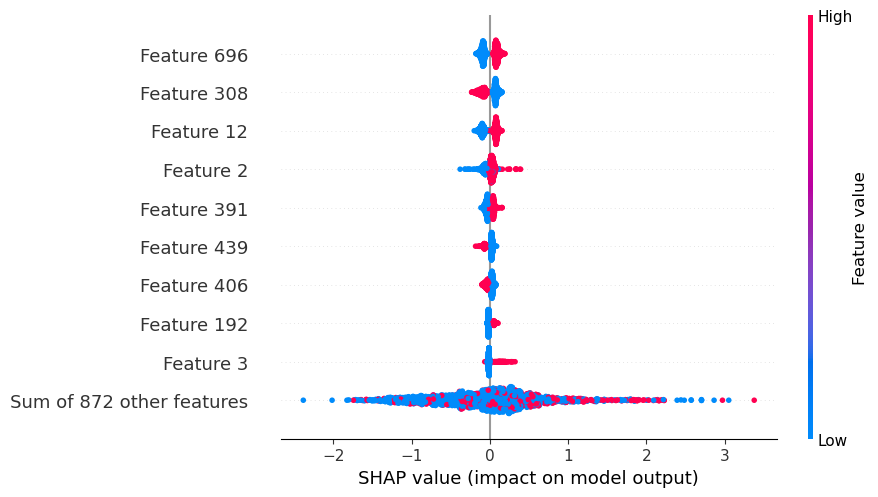

In [63]:
shap.plots.beeswarm(shap_values)

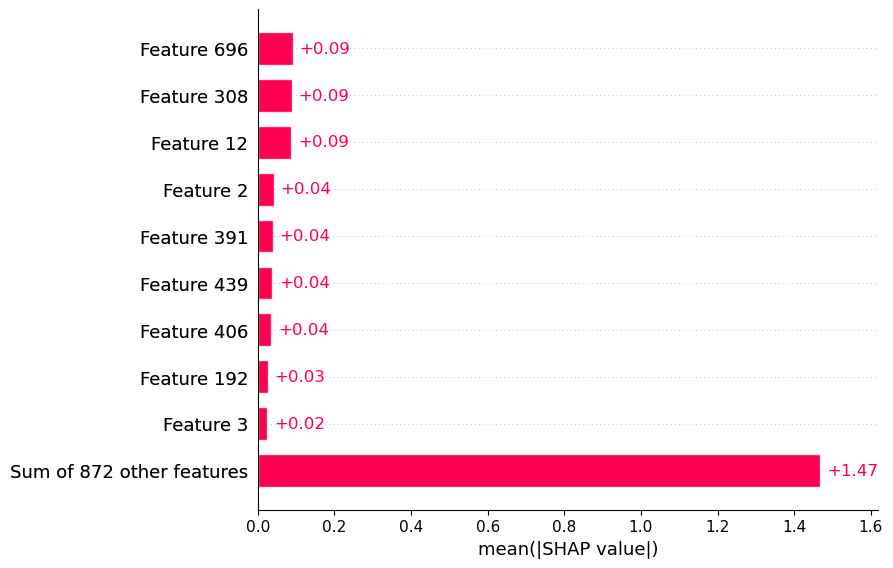

In [64]:
shap.plots.bar(shap_values)